In [1]:
include("../scripts/kf.jl")

draw (generic function with 8 methods)

In [2]:
mutable struct EstimatedLandmark <: AbstractLandmark
    pos
    id
    cov
end

In [4]:
function EstimatedLandmark_()
    self = EstimatedLandmark(ntuple(x->nothing, fieldcount(EstimatedLandmark))...)
    self.pos = [0.0, 0.0]
    self.id = nothing
    self.cov = [1 0; 0 2]
    return self
end

EstimatedLandmark_ (generic function with 2 methods)

In [5]:
function draw(self::EstimatedLandmark, ax, elems)
    if isnothing(self.cov)
        return
    end
    
    c = ax.scatter(self.pos[1], self.pos[2], s=100, marker="*", label="landmarks", color="blue")
    elems = vcat(elems, c)
    elems = vcat(elems, ax.text( self.pos[1], self.pos[2] , string("id:", string(self.id)), fontsize=10))
    
    e = sigma_ellipse(self.pos, self.cov, 3)
    elems = vcat(elems, [ax.add_patch(e)])

end

draw (generic function with 9 methods)

In [6]:
mutable struct MapParticle <: AbstractParticle
    pose
    weight
    map
end

In [13]:
function MapParticle_(init_pose, weight, landmark_num)
    self = MapParticle(ntuple(x->nothing, fieldcount(MapParticle))...)
    self.pose = init_pose
    self.weight = weight
    self.map = Map()
    
    for i in 1:landmark_num
        append_landmark(self.map, EstimatedLandmark_())
    end
    return self
end

MapParticle_ (generic function with 1 method)

In [14]:
mutable struct FastSlam <: AbstractMcl
    particles
    map
    distance_dev_rate
    direction_dev
    motion_noise_rate_pdf
    ml
    pose
end

In [15]:
function FastSlam_(envmap, init_pose, particle_num, landmark_num, motion_noise_stds=Dict("nn"=>0.19, "no"=>0.001, "on"=>0.13, "oo"=>0.2),
        distance_dev_rate=0.14, direction_dev=0.05)
    self = FastSlam(ntuple(x->nothing, fieldcount(FastSlam))...)
    self.particles =[Particle(init_pose, 1.0/particle_num) for i in 1:particle_num]
    self.map = envmap
    self.distance_dev_rate = distance_dev_rate
    self.direction_dev = direction_dev
    v = motion_noise_stds
    c = Diagonal([v["nn"]^2, v["no"]^2, v["on"]^2, v["oo"]^2])
    self.motion_noise_rate_pdf = MvNormal(zeros(4), c)
    self.ml = self.particles[1]
    self.pose = self.ml.pose
    
    self.particles = [MapParticle_(init_pose, 1.0/particle_num, landmark_num) for i in 1:particle_num]
    self.ml = self.particles[1]
    return self
end

FastSlam_ (generic function with 4 methods)

In [16]:
function draw(self::FastSlam, ax, elems)
    xs = [p.pose[1] for p in self.particles]
    ys = [p.pose[2] for p in self.particles]
    vxs = [cos(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    vys = [sin(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    elems = vcat(elems, ax.quiver(xs, ys, vxs, vys, angles="xy", scale_units="xy", color="blue", alpha=0.5))
    draw(self.ml.map, ax, elems)
end

draw (generic function with 10 methods)

In [17]:
function trial()
    time_interval = 1.0
    world = World_(30, time_interval, false)
    
    m = Map()
    for ln in [[-4.0, 2.0], [2.0, -3.0], [3.0, 3.0]]
        append_landmark(m, Landmark(ln))
    end
    append(world, m)
    
    initial_pose = [0.0, 0.0, 0.0]
    pf = FastSlam_(m, initial_pose, 100, length(m.landmarks))
    a = EstimationAgent_(time_interval, 0.2, 10.0/180*pi, pf)
    r = Robot_(initial_pose, sensor=Camera_(m), agent=a, color="red")
    append(world, r)
    draw(world)
    showanim("test.mp4")
end

trial (generic function with 1 method)

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQABAxttZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAM01liIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiA7BC5NJlvfhKIWPSXi/zA6JYDLoQAMQkginty7NGv2twoUk3+x++sOjYLO23GkLnX3zZEYn6a9vQcRQLf67K7SBvVrJ/o4DfjcfmL80ItpTpOBk9UoqIRYyXX9Jp26SG/qkhzXvDYJnUDUkXMWTV9xgIkId/B0DL63tzWtJoDT3qBLshsubVeON8CDX6ibsLgVVQ4A0D7tGbVkDzT/KsUAH7fA8ber7HvEJfThyzrLkSWNw9QjQzXk0jYHioNxDFOC0u5P/6flbarG27qxKpcR1g3jAe/uyNQkdibir9L1oZNoxCL9nTz5Do7WCxbfdwBz786P6Gt3+a9qFmQoe2Qlbs6zkxnOY8FmvubMXtnqJ20rtvpHrl79t6nq8q+9ZGR6BdRh00t3Aigy2K6jkGX8xF2NbE0107yMuMhNJ8nLf3bEUDA1W0TIui6TwnLCPxsZoeNH9a4AHuu+fRe2d9XIIXx50n+Od5GeJI+w65vIpFM505Ok+93xmUtuVHGQ3eacRH3D3LWgvRa8VlJf0rW/lw3pNMKrLBfC42qBBbPPf9t2q9s/FQBF+eHBqb/CB1m4Za8y+nnzp4tqwGv7FWpgi0iuEQ4W59KBcdz8U2ukqDc8XRyHIGUzQWrN2B2hH41jBxiu8GM2/yYQASZZNk6cnN992hxnRVU/+oJK/JdfpqQC09Qp+0lkF/MADsjxgxnmkyiD4cJFbjyc/bIvgLZswUinp9mbC+OqS+B3Ka9nIBrRd8URZmZnmnn6jGyox4iNCMwrJzVTMejzVjwcpF5gWSDBAd3fPNh4CYMsOqHHJJ1HIr3/3KzKyJnKGIPwD1EjEsKeZY5DEKBN4Lbx26JgmuTA0OP3RbWAeL+irUAAdvximab6tYtmIDtSY3U913HQxRgmhp/597w3yfZ52GLUciYxAXWl/cWNdO3OLelzk/jyowoJf3B3AMMnRPbQ6GhaPpBASX0ILIG7R4/0xLCQjBxlUT3CimocEI1bCoHqJHdBrpvSJZnDTpONf/gtqa5GIoVB68mB3RB7DdCCQ7R8vo6+F4uInhJnnCTP6UUqWtnOJdIiDTn+TRqHzKzMu1sCJz/964zvY6hfKqGqO4wWGm+/3q1EOtQlXwLtPfbjS6BOfxZTGbxFld2UPTC+AJGcV1RI0N/W31BVKfAKMfcRPlpIzLCWypGBwa4MCsqSui3GLjnM4BHj+eNyIDJWRP4IdKTKyECUOTRlv9FKOubJaxfoQp6LPgAA5Oe5XHzH+VdHA7xOCeniNv/JPr+JhWh62zlWAruNoWd3vQ2udrDuP1p5LbIf83yC47Bbhtf6UVX1P3cZ5RhtSc+fq3fr1wJP/vhjA+K7upo70SrDRQGvHdLhHtr6HArgt1n2N7+jyRaupUIGVkZYOuuf5Cv35czta7so3HSvVZ+WW+l6r/QBv3EQqIpgnxCZxiFjE88R5xHc8f+kfcbmf2hEJB8vAySMoWo5j9/vtS/DpJIHVQOsRxbwlgCXkhQQLMXAKmpu3CFOXjoYNbDdI+zmGIyrs9pRYb+gW3cWRFZ+KZKsbJ4+cC8LHDzqeWMELqqAxs4Kn+A1UpGIsH/MGGVwstYWHATjiC3GNPpWiFCRCbGNkLRnFMe3atxeOJFwcat2/Y33eoGEn8kyUM3cM0D2lojFJ6ILaoZcFtfmmH/9aZR49nSX8eYOQyO0xhFL0fPUGRRCnBTEV48nCVAR7fUw8taPJbAgdaYGJq1xoNLbG0GmW4agsE93J06V2MIGV6pV2YY0SZ8ibVSOfRhQwtNRQ6+owdvpL1zW7OfSxZEDuQFmboYW1QxgGCESoacctdeSGEXXZae85s2LEmf6i1JgNHxXWf9QpYNz9K54Q2y3GME4bZjuQ6VHob4ZwTi3bPEo+g1ug6V3KfjUgYTbEK1vSXYNXwVsI1tkULgnaq4/7RjRClDkpH2b2pvjWRRJ6MguLjUoObcCQYbydXIlHf6oDNUkGzqWTu/7KPXqO/hdgNoVJo98A4qE7gignY6kMVVV+SZWbnHvqlDWL51YnbKQKeOOo8iwyQePsHZJ/N/WbARzYVbCYdyW6TFJiotMByf8zNZfPEVMP2+3s3onZy2Pj15SPDOw1WEBwtrWk6LQDRCDzOdelD75dnSu3DdKSjWmSLZ7ImNAplQyWc/KMlh7BbXZZx12XriS0JrcdekxdV/dEHAKPjTYVJIunm/QL42hhn31QCxXNwsbxh+hnxJCvQpcz4RpZM5sol2jsncK+yu3mG+atK37cpjK3/o37bu1svv461RrjZpq33lGM9WNXRa+0p9q7JnBCnjp1JjYtkaoua1+LBZRBu3GMhTSEiClNI4fnQH0O3WMagBcM78GMG6pE9ARHmsMxV3zvC0azpwWRzOKCGWhdaA2vvmVeAN37GRXxhI9FatZoPz/blGgRMu0MpeQYWdVEXcWzA6zXUDYdPdB5WS3tFU95ge8wAcruHQ6+kzjYa7cj/ZZoFo1yc2E2zVjX9MiCVzY1p7WohRAogjYzXiK/HCjVprA5qFe8cVcM04oU/u9/jHsj7DZomcCDHtm7HSO2YbzU//CZpe85ZUyy+/BIT7Jz+KZQoKZe5ZtGPbdoeCCUMp3ARCDQ7SYkSJ5A3BzgV5HkCeqEVkOYJMEJPneqvR7eUBbh9vJzNl04R3OIpGMHhHVkzNo1yvxHudS+lkgicyEOLxE/Tjq+PFSlPtPvCjaiiYKPMvy2Aivvf9D55SzvJMbrVTiIMu6QEyXqdK6ehDWYnNlGoGZzc8pxaqTkZ1OeuRZCBqX5X5oagLPO8usYP78UQYaHcEUxPlUIyT8G6CakmtiO+geOlDwRQtzVzUC/nBcWQYjm1i8JImqbb1HP0qPhXxDwBxFfrrHehHUTu+uW/eQR0y3

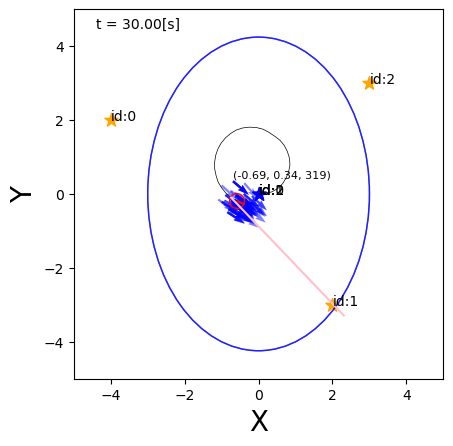

In [18]:
trial()